In [ ]:
'''
we have the h5 file which contains table of tensors -> eeg_tensor, caption_tokensised, metadata_tensor

phase1) constructing a STGT Encoder - Spatio-Temporal Graph-Transformer 
- build to handle both spatial and temporal features
- its a 2 stage hybrid encoder 
A) Spatial modeling using GCN - Graph Convolutional Network
step1: 62 EEG electrodes as nodes in a graph. create a matrix A for 62 channels based on physical distance of the electrodes. 
step2: Save it as a file and load as torch.tensor.
B) Temporal modeling with Transformer
step1: After each timestep has a spatially aware vector, the transformet looks across all the timesteps and see whcih matter moew


'''

In [10]:
import mne
import numpy as np
import torch as torch
from scipy.spatial.distance import cdist


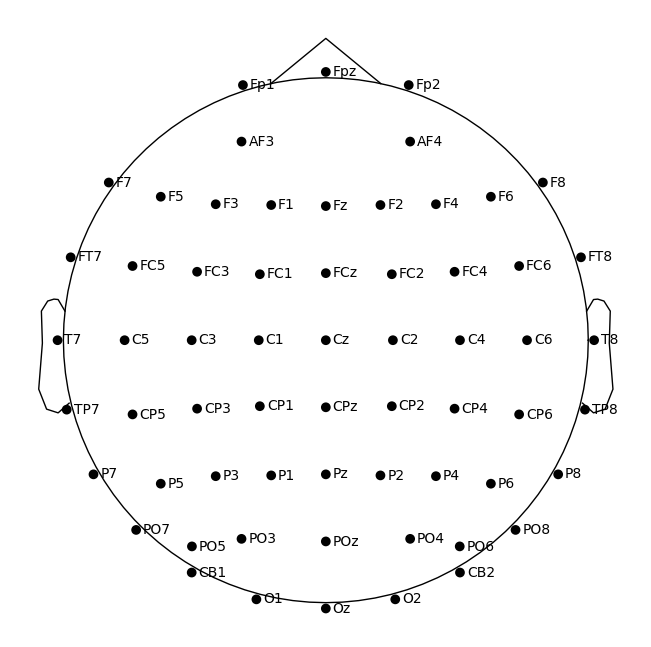

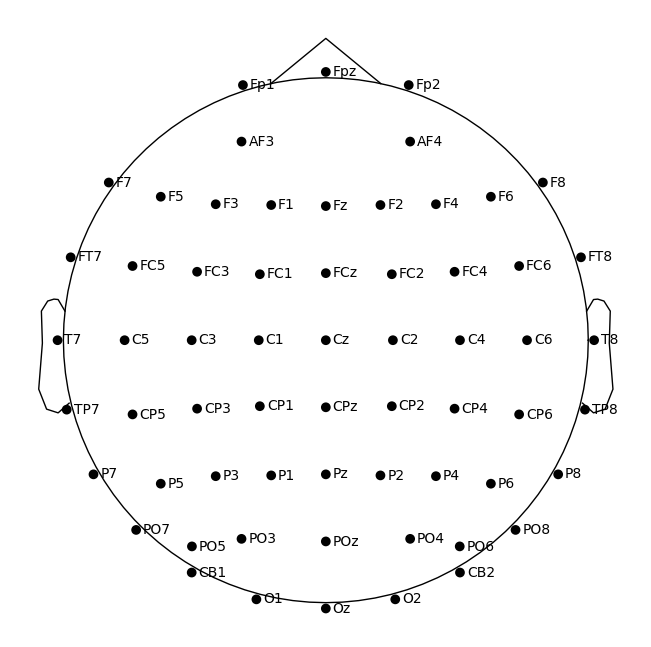

In [3]:
# Path to your .locs file
locs_path = "/home/sanu/Projects/Capstone_EEG/Dataset/SEED-DV/channel_62_pos.locs"

# Read the custom montage
montage = mne.channels.read_custom_montage(locs_path)

# Plot the montage
montage.plot(show_names=True)


In [4]:
# Extract 3D coordinates of each channel from montage
pos_dict = montage.get_positions()['ch_pos']  # dict {channel_name: (x, y, z)}
channels = list(pos_dict.keys())
coords = np.array([pos_dict[ch] for ch in channels])  # shape: (n_channels, 3)

# Step 1: Euclidean distance matrix
dist_matrix = cdist(coords, coords, metric='euclidean')

# Step 2: Gaussian kernel weighting
sigma = np.mean(dist_matrix[dist_matrix > 0])  # exclude zeros from diagonal
W = np.exp(- (dist_matrix ** 2) / (2 * sigma ** 2))

# Step 3: Remove self-connections
np.fill_diagonal(W, 0)

# Step 4 (Optional): Sparsify weak connections
threshold = 0.1
W[W < threshold] = 0

print(W.shape)
print(W)


(62, 62)
[[0.         0.96867971 0.88322957 ... 0.28125172 0.2726857  0.27634123]
 [0.96867971 0.         0.96867971 ... 0.27244283 0.27854582 0.2972383 ]
 [0.88322957 0.96867971 0.         ... 0.28125172 0.302572   0.33783173]
 ...
 [0.28125172 0.27244283 0.28125172 ... 0.         0.97808982 0.91658052]
 [0.2726857  0.27854582 0.302572   ... 0.97808982 0.         0.97808982]
 [0.27634123 0.2972383  0.33783173 ... 0.91658052 0.97808982 0.        ]]


In [8]:
# ---- Symmetric GCN Normalization ----
# Degree matrix
D = np.diag(W.sum(axis=1))
# Avoid division by zero for isolated nodes
D_inv_sqrt = np.linalg.inv(np.sqrt(D + np.finfo(float).eps))
# Normalized adjacency: A_hat = D^{-1/2} * (W + I) * D^{-1/2}
A_hat = D_inv_sqrt @ (W + np.eye(W.shape[0])) @ D_inv_sqrt
print(A_norm)
#this normalisation is done so that Every electrode’s update has balanced influence regardless of how many strong connections it has.
#Without normalization, those dense areas(with stronger connection to neighbours) dominate the graph aggregation — not necessarily because they’re more important, but because they’re more connected.

[[0.         0.03046688 0.02773633 ... 0.00834622 0.00809917 0.00822927]
 [0.03046688 0.         0.03046688 ... 0.00809734 0.00828604 0.00886529]
 [0.02773633 0.03046688 0.         ... 0.00834622 0.00898683 0.01006042]
 ...
 [0.00834622 0.00809734 0.00834622 ... 0.         0.02745212 0.02579321]
 [0.00809917 0.00828604 0.00898683 ... 0.02745212 0.         0.02754844]
 [0.00822927 0.00886529 0.01006042 ... 0.02579321 0.02754844 0.        ]]


In [12]:
# Step 5: Convert to torch tensor (float32)
A_hat_tensor = torch.tensor(A_hat, dtype=torch.float32)
print("Adjacency matrix shape:", A_hat_tensor.shape)
print(A_hat_tensor)

Adjacency matrix shape: torch.Size([62, 62])
tensor([[0.0314, 0.0305, 0.0277,  ..., 0.0083, 0.0081, 0.0082],
        [0.0305, 0.0315, 0.0305,  ..., 0.0081, 0.0083, 0.0089],
        [0.0277, 0.0305, 0.0314,  ..., 0.0083, 0.0090, 0.0101],
        ...,
        [0.0083, 0.0081, 0.0083,  ..., 0.0280, 0.0275, 0.0258],
        [0.0081, 0.0083, 0.0090,  ..., 0.0275, 0.0281, 0.0275],
        [0.0082, 0.0089, 0.0101,  ..., 0.0258, 0.0275, 0.0282]])


In [17]:
torch.save(A_hat_tensor, "Ahat_adjacency_matrix.pt")

#to load later do the below

# import torch
# a_hat_tensor = torch.load("adjacency_matrix.pt")
# print(a_hat_tensor.shape)